In [2]:
image_diectories = '/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke'

In [3]:
!ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke

Fire  Neutral  Smoke


In [4]:
ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke/Fire/* | wc -l 

2071


In [5]:
ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke/Neutral/* | wc -l 

2071


In [6]:
ls /data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke/Smoke/* | wc -l 

2071


In [7]:
import numpy as np
import pathlib
data_directory = pathlib.Path('/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke')
print(data_directory)
classes = np.array([item.name for item in data_directory.glob('*') ])# and item.name != "Sourabh Fire"] )
classes.sort()
classes

/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke


array(['Fire', 'Neutral', 'Smoke'], dtype='<U7')

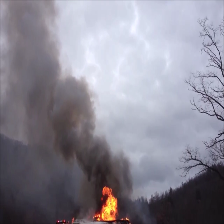

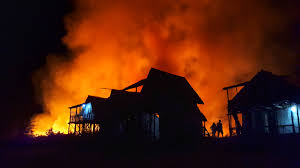

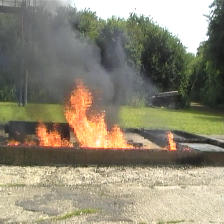

In [8]:
from IPython.display import Image, display

Fire = list(data_directory.glob('Fire/*'))

for image_path in Fire[:3]:
    display(Image(str(image_path)))

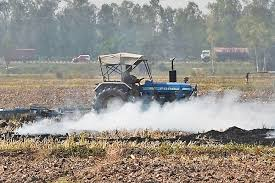

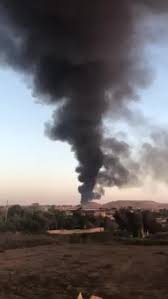

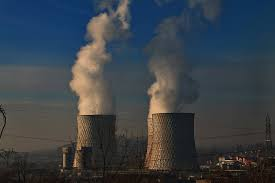

In [9]:
from IPython.display import Image, display

Smoke = list(data_directory.glob('Smoke/*'))

for image_path in Smoke[:3]:
    display(Image(str(image_path)))

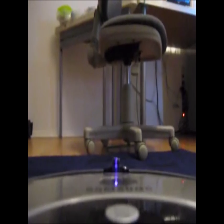

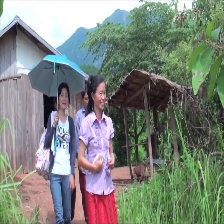

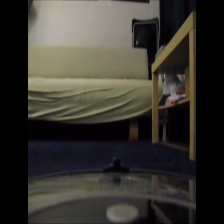

In [10]:
from IPython.display import Image, display

Neutral = list(data_directory.glob('Neutral/*'))

for image_path in Neutral[:3]:
    display(Image(str(image_path)))

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

IMAGE_SIZE = 124
BATCH_SIZE = 32
dataset_directory = '/data/cmpe256-01-su2020/blaze_sight/tmp_withSmoke'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_directory,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training')

val_generator = datagen.flow_from_directory(
    dataset_directory,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='validation')

Found 4971 images belonging to 3 classes.
Found 1242 images belonging to 3 classes.


In [12]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

image_batch_train, label_batch_train = next(iter(train_generator))

image_batch_train, label_batch_train = next(iter(train_generator))


Image batch shape:  (32, 124, 124, 3)
Label batch shape:  (32, 3)


In [13]:
print (train_generator.class_indices)

{'Fire': 0, 'Neutral': 1, 'Smoke': 2}


In [14]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
print(labels)
with open('labels.txt', 'w') as f:
  f.write(labels)

Fire
Neutral
Smoke


In [15]:
!cat labels.txt

Fire
Neutral
Smoke

In [16]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0])
      plt.axis('off')

In [17]:
print(label_batch_train)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [18]:
#Definition to plot history

def plot_history(history, metric, val_metric,EPOCHS):
    
    acc = history.history[metric]
    val_acc = history.history[val_metric]

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig=plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([min(plt.ylim()),1])
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()
    fig.savefig('graphs/traininghistory.pdf')


In [19]:
labelDataset=labels.split('\n')


In [20]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg16 import VGG16

numclasses=train_generator.num_classes

def build_model_vgg16():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu'))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())

    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.10)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [21]:
model_vgg16=build_model_vgg16()
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 15,013,067
Trainable params: 298,379
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
EPOCHS = 50
history_vgg16 = model_vgg16.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 121s 775ms/step - loss: 1.0200 - acc: 0.5371 - val_loss: 1.0973 - val_acc: 0.4122
Epoch 2/50
156/156 [==============================] - 126s 807ms/step - loss: 0.9130 - acc: 0.6256 - val_loss: 1.0583 - val_acc: 0.4775
Epoch 3/50
156/156 [==============================] - 121s 773ms/step - loss: 0.8251 - acc: 0.6902 - val_loss: 1.0421 - val_acc: 0.5161
Epoch 4/50
156/156 [==============================] - 106s 681ms/step - loss: 0.7403 - acc: 0.7493 - val_loss: 1.0414 - val_acc: 0.5177
Epoch 5/50
156/156 [==============================] - 113s 723ms/step - loss: 0.6702 - acc: 0.7872 - val_loss: 1.0683 - val_acc: 0.5016
Epoch 6/50
156/156 [==============================] - 126s 806ms/step - loss: 0.6110 - acc: 0.8123 - val_loss: 1.0124 - val_acc: 0.5362
Epoch 7/50
156/156 [==============================] - 121s 776ms/step - loss: 0.5642 - acc: 0.8312 - val_loss: 1.0404 - val_acc: 0.5451
Epoch

In [23]:
# Export the model to a SavedModel
model_vgg16.save('/data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16', save_format='tf')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16/assets


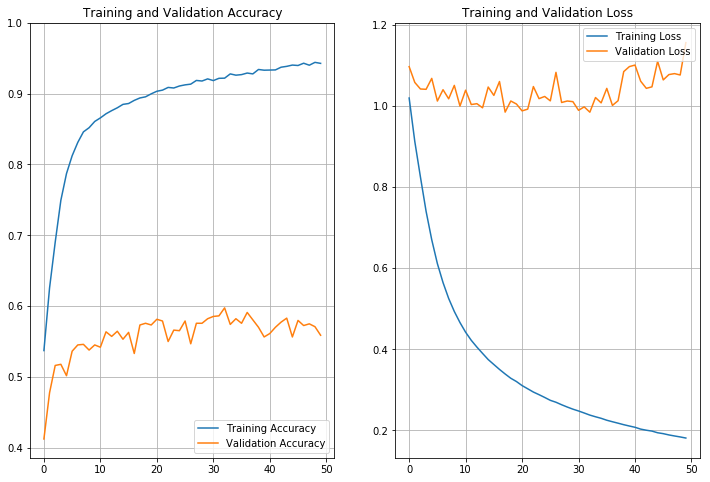

In [25]:
history= history_vgg16
plot_history(history,'acc','val_acc',EPOCHS)

In [29]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l1

numclasses=train_generator.num_classes

def build_model_vgg16_2():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu',activity_regularizer=l1(0.001)))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [30]:
model_vgg16_2=build_model_vgg16_2()
model_vgg16_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 153       
Total params: 15,013,067
Trainable params: 298,379
Non-trainable params: 14,714,688
____________________________________

In [31]:
EPOCHS = 50
history_vgg16_2 = model_vgg16_2.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 128s 824ms/step - loss: 0.9258 - acc: 0.5611 - val_loss: 1.1675 - val_acc: 0.4493
Epoch 2/50
156/156 [==============================] - 133s 853ms/step - loss: 0.6544 - acc: 0.7415 - val_loss: 1.1503 - val_acc: 0.4718
Epoch 3/50
156/156 [==============================] - 131s 842ms/step - loss: 0.5408 - acc: 0.8027 - val_loss: 1.2054 - val_acc: 0.4710
Epoch 4/50
156/156 [==============================] - 130s 831ms/step - loss: 0.4367 - acc: 0.8443 - val_loss: 1.2988 - val_acc: 0.4549
Epoch 5/50
156/156 [==============================] - 130s 831ms/step - loss: 0.3705 - acc: 0.8735 - val_loss: 1.0279 - val_acc: 0.5749
Epoch 6/50
156/156 [==============================] - 123s 788ms/step - loss: 0.3370 - acc: 0.8871 - val_loss: 1.2457 - val_acc: 0.5145
Epoch 7/50
156/156 [==============================] - 112s 716ms/step - loss: 0.3120 - acc: 0.8934 - val_loss: 1.0773 - val_acc: 0.5419
Epoch

In [32]:
# Export the model to a SavedModel
model_vgg16_2.save('/data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16_2', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16_2/assets


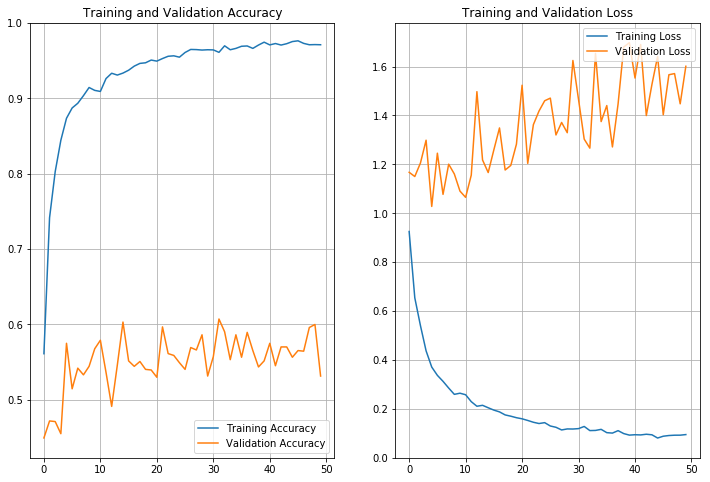

In [33]:
history= history_vgg16_2
plot_history(history,'acc','val_acc',EPOCHS)

In [41]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l1

numclasses=train_generator.num_classes

def build_model_vgg16_3():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu',activity_regularizer=l1(0.001)))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(16, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [42]:
model_vgg16_3=build_model_vgg16_3()
model_vgg16_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 51        
Total params: 15,012,323
Trainable params: 297,635
Non-trainable params: 14,714,688
____________________________________

In [43]:
EPOCHS = 50
history_vgg16_3 = model_vgg16_3.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 120s 768ms/step - loss: 0.8464 - acc: 0.6393 - val_loss: 1.1285 - val_acc: 0.5298
Epoch 2/50
156/156 [==============================] - 132s 848ms/step - loss: 0.5261 - acc: 0.8260 - val_loss: 1.0635 - val_acc: 0.5636
Epoch 3/50
156/156 [==============================] - 93s 599ms/step - loss: 0.4223 - acc: 0.8704 - val_loss: 1.1378 - val_acc: 0.5572
Epoch 4/50
156/156 [==============================] - 119s 762ms/step - loss: 0.3525 - acc: 0.8888 - val_loss: 1.0366 - val_acc: 0.5974
Epoch 5/50
156/156 [==============================] - 131s 840ms/step - loss: 0.3154 - acc: 0.9065 - val_loss: 1.1421 - val_acc: 0.5870
Epoch 6/50
156/156 [==============================] - 134s 861ms/step - loss: 0.2771 - acc: 0.9185 - val_loss: 1.4021 - val_acc: 0.5322
Epoch 7/50
156/156 [==============================] - 136s 871ms/step - loss: 0.2592 - acc: 0.9234 - val_loss: 1.1799 - val_acc: 0.6111
Epoch 

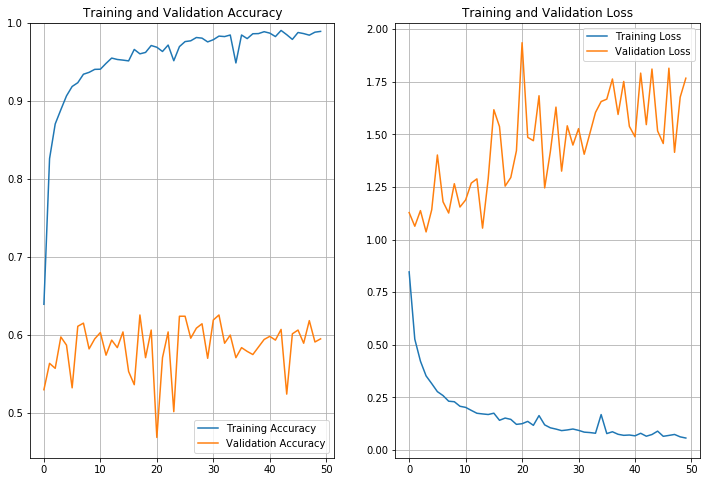

In [44]:
history= history_vgg16_3
plot_history(history,'acc','val_acc',EPOCHS)

In [45]:
# Export the model to a SavedModel
model_vgg16_3.save('/data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16_3', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16_3/assets


In [46]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.regularizers import l1

numclasses=train_generator.num_classes

def build_model_vgg16_4():
    
    IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

    # Create the base model from the pre-trained model VGG19 V2
    base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Conv2D(64, 3, activation='relu',activity_regularizer=l1(0.001)))
    #model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
#     model.add(layers.Flatten())
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(16, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(8, activation='relu',activity_regularizer=l1(0.001)))
    model.add(layers.Dense(numclasses, activation='softmax'))

    loss = losses.categorical_crossentropy#losses.sparse_categorical_crossentropy
  #one-hot encoded, use categorical_crossentropy. Examples (for a 3-class classification): [1,0,0] , [0,1,0], [0,0,1] But if your Yi's are integers, use sparse_categorical_crossentropy. Examples for above 3-class classification problem: [1] , [2], [3]
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9)#optimizers.RMSprop(lr=1e-4)#optimizers.SGD(lr=0.001) #Adam(lr=0.001)
    model.compile(loss=loss,
              optimizer=optimizer,
              metrics=['acc'])

    return model

In [47]:
model_vgg16_4=build_model_vgg16_4()
model_vgg16_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 64)          294976    
_________________________________________________________________
global_average_pooling2d_6 ( (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_16 (Dense)             (None, 3)                

In [48]:
EPOCHS = 200
history_vgg16_4 = model_vgg16_4.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=val_generator)

Train for 156 steps, validate for 39 steps
Epoch 1/200
156/156 [==============================] - 111s 713ms/step - loss: 0.9651 - acc: 0.5510 - val_loss: 1.1487 - val_acc: 0.3857
Epoch 2/200
156/156 [==============================] - 115s 734ms/step - loss: 0.6420 - acc: 0.7691 - val_loss: 1.3356 - val_acc: 0.4316
Epoch 3/200
156/156 [==============================] - 124s 795ms/step - loss: 0.5100 - acc: 0.8316 - val_loss: 1.1745 - val_acc: 0.4919
Epoch 4/200
156/156 [==============================] - 135s 866ms/step - loss: 0.4099 - acc: 0.8781 - val_loss: 1.2177 - val_acc: 0.5459
Epoch 5/200
156/156 [==============================] - 138s 882ms/step - loss: 0.3347 - acc: 0.8992 - val_loss: 1.2532 - val_acc: 0.5459
Epoch 6/200
156/156 [==============================] - 136s 872ms/step - loss: 0.3106 - acc: 0.9069 - val_loss: 1.2298 - val_acc: 0.5435
Epoch 7/200
156/156 [==============================] - 134s 862ms/step - loss: 0.3086 - acc: 0.9050 - val_loss: 1.2841 - val_acc: 0.520

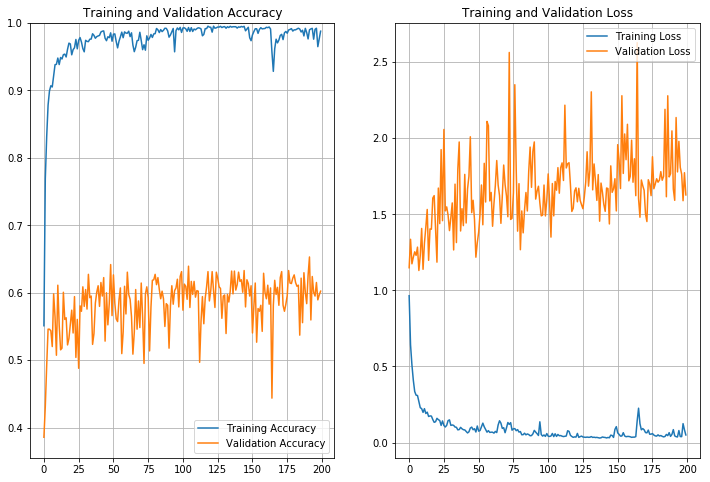

In [49]:
history= history_vgg16_4
plot_history(history,'acc','val_acc',EPOCHS)

In [50]:
# Export the model to a SavedModel
model_vgg16_4.save('/data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16_4', save_format='tf')


INFO:tensorflow:Assets written to: /data/cmpe256-01-su2020/blaze_sight/models/apporv/model_vgg16_4/assets


# On comparison I found model 2 i.e model_vgg16_2 as the optimum on basis of classwise accuracy compared using comparsion file